In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.utils.data.datasets.epf import EPF, EPFInfo
from src.utils.pytorch.ts_dataset import TimeSeriesDataset
from src.utils.pytorch.ts_loader import TimeSeriesLoader
from src.nbeats.nbeats import Nbeats

This notebook presents an example on how to use the NBEATSx model, including the Dataset and Loader objects which comprise our full pipeline. We will train the model to forecast the last available week of the NP market described in the paper.

Note: the hyperparameters of the model in this example do not correpond to the configuration used on the main results of the paper.

# Load data

In [2]:
Y_df, X_df, _ = EPF.load_groups(directory='./data', groups=['NP'])
Y_df.head()

,unique_id,ds,y
0,NP,2013-01-01 00:00:00,31.05
1,NP,2013-01-01 01:00:00,30.47
2,NP,2013-01-01 02:00:00,28.92
3,NP,2013-01-01 03:00:00,27.88
4,NP,2013-01-01 04:00:00,26.96


# Dataset and Data Loader

In [3]:
# train_mask: 1 to keep, 0 to mask
train_mask = np.ones(len(Y_df))
train_mask[-168:] = 0 # Last week of data (168 hours)

# Dataset object. Pre-process the DataFrame into pytorch tensors and windows.
ts_dataset = TimeSeriesDataset(Y_df=Y_df, X_df=X_df, ts_train_mask=train_mask)

# Loaders object. Sample windows of dataset object.
# For more information on each parameter, refer to comments on Loader object.
train_loader = TimeSeriesLoader(model='nbeats',
                                ts_dataset=ts_dataset,
                                window_sampling_limit=365*4*24,
                                offset=0,
                                input_size=7*24,
                                output_size=24,
                                idx_to_sample_freq=24,
                                batch_size=512,
                                is_train_loader=True,
                                shuffle=True)

# Validation loader (note: in this example we are also validating on the period to forecast)
val_loader = TimeSeriesLoader(model='nbeats',
                              ts_dataset=ts_dataset,
                              window_sampling_limit=365*4*24,
                              offset=0,
                              input_size=7*24,
                              output_size=24,
                              idx_to_sample_freq=24,
                              batch_size=512,
                              is_train_loader=False,
                              shuffle=False)

True
True
True
Processing dataframes ...
Creating ts tensor ...


# Instantiate and train model

In [4]:
# Dictionary with lags to include for y and each exogenous variable.
# Eg: -1 corresonds to future (available for exogenous), -2 correponds to last available day, and so on.
include_var_dict = {'y': [-8,-4,-3,-2],
                    'Exogenous1': [-8,-2,-1],
                    'Exogenous2': [-8,-2,-1],
                    'week_day': [-1]}

model = Nbeats(input_size_multiplier=7,
                output_size=24,
                shared_weights=False,
                initialization='glorot_normal',
                activation='selu',
                stack_types=['identity']+['exogenous_tcn'],
                n_blocks=[1, 1],
                n_layers=[2, 2],
                n_hidden=[[512,512], [512,512]],
                n_harmonics=0, # not used with exogenous_tcn
                n_polynomials=0, # not used with exogenous_tcn
                x_s_n_hidden = 0,
                exogenous_n_channels=9,
                include_var_dict=include_var_dict,
                t_cols=ts_dataset.t_cols,
                batch_normalization = True,
                dropout_prob_theta=0.1,
                dropout_prob_exogenous=0,
                learning_rate=0.001,
                lr_decay=0.5,
                n_lr_decay_steps=3,
                early_stopping=10,
                weight_decay=0,
                l1_theta=0,
                n_iterations=2_000,
                loss='MAE',
                loss_hypar=0.5,
                val_loss='MAE',
                seasonality=24, # not used: only used with MASE loss
                random_seed=1)

In [5]:
model.fit(train_ts_loader=train_loader, val_ts_loader=val_loader, eval_steps=50)



============================== Start fitting ==============================
Step: 50, Time: 5.204, Insample MAE: 8.97106, Outsample MAE: 8.39790
Step: 100, Time: 7.026, Insample MAE: 2.26137, Outsample MAE: 3.73254
Step: 150, Time: 8.734, Insample MAE: 1.94567, Outsample MAE: 3.35698
Step: 200, Time: 10.419, Insample MAE: 1.68058, Outsample MAE: 2.71383
Step: 250, Time: 12.130, Insample MAE: 1.67209, Outsample MAE: 1.94615
Step: 300, Time: 13.557, Insample MAE: 1.62759, Outsample MAE: 2.02586
Step: 350, Time: 14.206, Insample MAE: 1.83810, Outsample MAE: 1.65587
Step: 400, Time: 14.834, Insample MAE: 1.80795, Outsample MAE: 3.04457
Step: 450, Time: 15.455, Insample MAE: 1.68912, Outsample MAE: 2.47475
Step: 500, Time: 16.102, Insample MAE: 1.62596, Outsample MAE: 2.29209
Step: 550, Time: 16.813, Insample MAE: 1.50280, Outsample MAE: 1.87254
Step: 600, Time: 17.447, Insample MAE: 1.49161, Outsample MAE: 1.84333
Step: 650, Time: 18.077, Insample MAE: 1.47221, Outsample MAE: 1.78914
Ste

In [6]:
y_true, y_hat, *_ = model.predict(ts_loader=val_loader, return_decomposition=False)

Text(0, 0.5, 'Price')

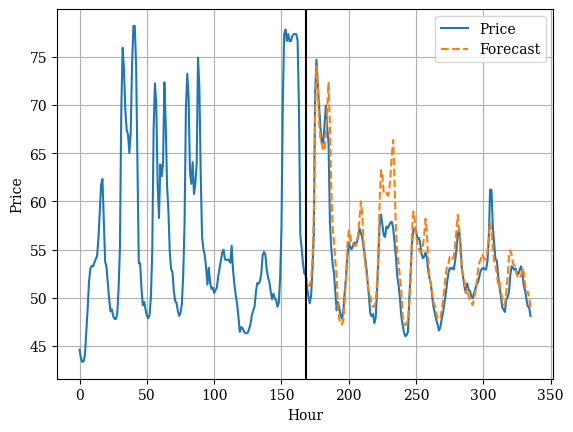

In [7]:
plt.plot(range(336), Y_df['y'].values[-336:], label='Price')
plt.plot(range(168,336), y_hat.flatten(), linestyle='dashed', label='Forecast')
plt.axvline(168, color='black')
plt.legend()
plt.grid()
plt.xlabel('Hour')
plt.ylabel('Price')